# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
_, processed_adult = load_dataset('adult')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [4]:
processed_adult.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week,sex,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.030671,1.134739,0.148453,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.837109,1.134739,-0.145920,-0.21666,-2.222153,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-0.042642,-0.420060,-0.145920,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


### 3. split train/test data.

In [17]:
'''UCI dataset'''
df = processed_adult.copy()
X = df.drop('income', axis=1)
y = df['income']



# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (22792, 106)
X_test shape: (9769, 106)


### 4. Train the original model

In [18]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8722489507626164


In [19]:
X_train['sex'].value_counts()

sex
1    15301
0     7491
Name: count, dtype: int64

In [20]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]


### 5. Evaluate the performance of original model

In [21]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.029912568628787994
original_train_DR: 0.030169442296028137


### 5. match majority with minority, and change its value from the other part.

2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 207
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 230
6. 开始整理minority部分的修改和majority部分的修改并且合并新数据,共修改437个数据点, 使用new training set训练新模型


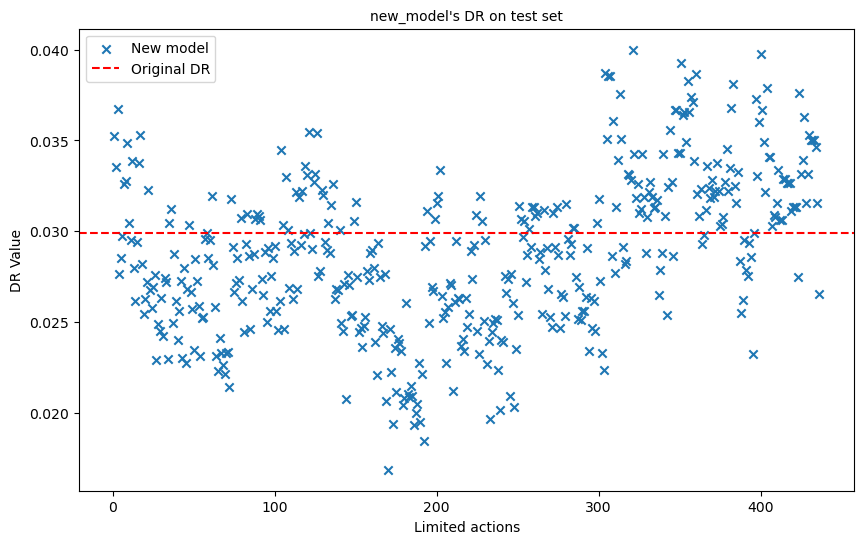

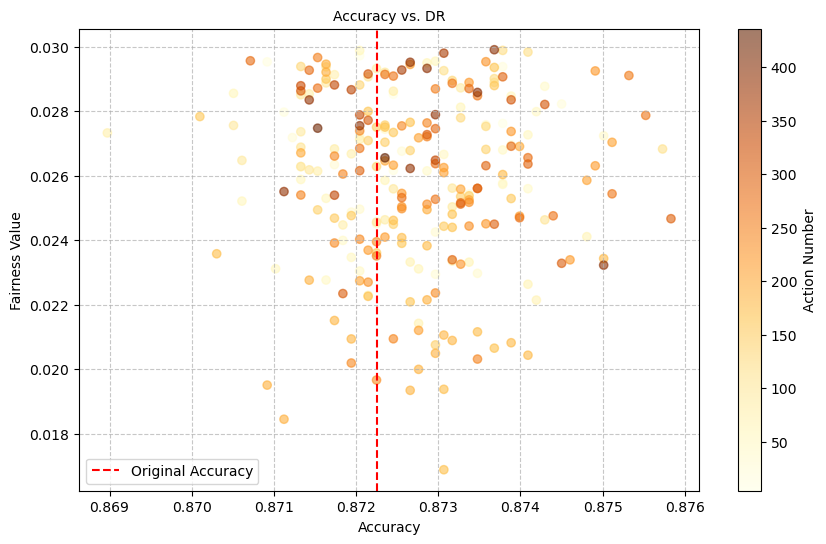

([0.035224758,
  0.033534933,
  0.036721505,
  0.02762494,
  0.02852695,
  0.029723246,
  0.03262409,
  0.032762077,
  0.034855228,
  0.030451672,
  0.029533299,
  0.033858124,
  0.027973723,
  0.0261647,
  0.029384714,
  0.033755217,
  0.035326563,
  0.028225467,
  0.025433457,
  0.026275823,
  0.027184283,
  0.032290522,
  0.02676237,
  0.025773397,
  0.026959967,
  0.027580833,
  0.022943221,
  0.024871955,
  0.024508858,
  0.02634353,
  0.024252746,
  0.027443316,
  0.027230915,
  0.02297187,
  0.030455774,
  0.031206155,
  0.024962474,
  0.028774602,
  0.026151102,
  0.023993792,
  0.025598167,
  0.027237805,
  0.023044443,
  0.027988868,
  0.022763712,
  0.026800528,
  0.030361498,
  0.026660873,
  0.025733225,
  0.023466853,
  0.028471485,
  0.027269866,
  0.02588331,
  0.023114134,
  0.025213117,
  0.02529907,
  0.029554252,
  0.02988459,
  0.028556675,
  0.029501691,
  0.03194618,
  0.02812563,
  0.025857283,
  0.023110017,
  0.02228825,
  0.024109261,
  0.023318347,
  0.02263

In [22]:
from src.experiments_approach4 import ExperimentNew4

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew4(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='adult',
                            original_Xtest_DR = original_test_DR,
                            original_Xtest_acc = accuracy,)
experiment.run_experiment()